# ２章　自然言語と単語の分散表現

### 自然言語処理とは？
私達が普段使う日本語や英語などを**自然言語**といい、自然言語処理とはこれをコンピュータに理解させる技術・分野のことである。  

言葉の意味の最小単位は「単語」です。この単語の意味をコンピュータに理解させる方法として３つ紹介します。  

- シソーラスによる手法  

- カウントベースの手法  

- 推論ベースの手法(word2vec)

In [1]:
#必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### シソーラスとは
**シソーラス**は類語辞書です。  
  
例えば"car"の類語には"autpmpbile"や"motorcar"があり、シソーラスには同じグループとして定義されています。  
  
また、シソーラスには単語の縦の関係性も定義されている場合があり、"car"であればその上には"motor vehicle"のように抽象的な単語、下には"SUV"などの具体的な単語が保存されています。  
  
### シソーラスの問題点
  
このシソーラスを使えばコンピュータに単語の意味を教えられそうですが、もちろん問題点もあります。  
  
時代の変化に対応するのが難しい、人の作業コストが高い、単語の細かいニュアンスを表現できない。  
  
このように人手によって意味を定義しようとするとどうしてもうまくいきません。ですので次からは人手を使わない手法を紹介していこうと思います。


### カウントベース
それではここからはシソーラスの代替案としてカウントベースの手法を紹介します。まずはコーパス呼ばれる大量のテキストデータを用意します。（はじめは短い一文のみで構成されたものを扱います。）

In [2]:
text = 'You say goodbye and I say hello.' #テキストデータ

text を単語単位に分割します。

In [3]:
text = text.lower() #小文字に変換
text = text.replace('.', ' .') #ピリオドの前にスペースを入れる
text

'you say goodbye and i say hello .'

In [4]:
words = text.split(' ') #スペースで区切る
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

以上の操作によってコーパスを単語のリストとして利用できるようになりました。
次は単語にIDを振って、IDのリストとして利用できるようにします。

In [5]:
word_to_id = {} #単語をIDに変換する辞書
id_to_word = {} #IDを単語に変換する辞書

for word in words:
    if word not in word_to_id: # 未登録の単語の場合
        new_id = len(word_to_id)
        word_to_id[word] = new_id #新しい単語を辞書に追加
        id_to_word[new_id] = word #新しいIDを辞書に追加                                                                                                      
print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
id_to_word[1] #IDから単語を引く

'say'

In [7]:
word_to_id['hello'] #単語からIDを引く

5

単語のID付ができました！
単語のリストを単語IDリストへ変換します。

In [8]:
corpus = [word_to_id[w] for w in words] #単語IDのリスト
print(corpus)
corpus = np.array(corpus) #numpyの配列に変換
corpus

[0, 1, 2, 3, 4, 1, 5, 6]


array([0, 1, 2, 3, 4, 1, 5, 6])

以上の操作（コーパスから単語IDへの変換）を前処理として関数を定義します。

In [9]:
#コーパスの前処理を関数化
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [10]:
#実験
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus) #単語IDのリスト

[0 1 2 3 4 1 5 6]


### 単語の分散表現

色の表現方法  
  
固有の名前  
    
それぞれの色につけられた名前。赤や青などのシンプルなものから複雑な色まで全てに固有のものが存在する。  
  
例：「コバルトブルー」、「マゼンタ」、「萌葱」、「山吹」など  
  
ベクトル表記  
    
ＲＧＢの３成分のベクトルとして表現する。どの成分がどれくらいあるか一目でわかる。  
  
例：萌葱→(R,G,B)=(0,108,79)  
  
単語もベクトル表現できないか？→**単語の分散表現**    
  
単語をベクトルで表現しようとするときに最初にぶつかるのは**何を数値としてベクトルにするか**です。  

自然言語処理の分野では「単語の意味は周囲の単語によって形成される」よいう大胆でシンプルな仮説がよく用いられ、今回もこれを駆使してベクトル表現をしていきます。  
  
カウントベースの手法では名前の通りある単語の周囲にどのような単語がどれだけ現れるかをカウントし、集計します。

![alt text](../pictures/pict1.png)

単語"say"に対して周囲に現れる単語の頻度を表で表しました。 
   
これは"say"という単語が[1,0,1,0,1,1,0]というベクトルで表現できるということを意味します。  
  
他の単語も同様に表し、まとめると下のようになります。

![alt text](../pictures/pict2.png)

In [11]:
#下準備
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [12]:
#共起行列の作成(手動)
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [13]:
print(C[0]) #単語IDが0のベクトル

[0 1 0 0 0 0 0]


In [14]:
print(C[4]) #単語IDが4のベクトル

[0 1 0 1 0 0 0]


In [15]:
print(C[word_to_id['goodbye']]) #goodbyeのベクトル

[0 1 0 1 0 0 0]


In [16]:
#共起行列を作成する関数
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)#共起行列の初期化
    
    for idx, word_id in enumerate(corpus): # np.ndenumerate()は多次元配列のインデックスと要素を返す
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx] # 左側の単語IDを取得
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx] # 右側の単語IDを取得
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

コーパス（テキスト）から共起行列を作成してみます。

In [17]:
#実験
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)
print(C)

[[0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]]


これで共起行列を作ることができたので次はベクトル同士の類似度を見ていきましょう。

## ベクトルの類似度
コサイン類似度の定義式
![alt text](../pictures/pict3.png)  
直感的には「２つのベクトルがどれだけ同じ方向を向いているか」を表します。
値域は[-1,1]

In [18]:
#コサイン類似度を求める関数
def cos_similarity(x, y, eps=1e-8): #epsは0割を防ぐための微小値
    nx = x / np.sqrt(np.sum(x**2) + eps) #xの正規化
    ny = y / np.sqrt(np.sum(y**2) + eps) #yの正規化
    return np.dot(nx, ny)

In [19]:
#実験
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  #「you」の単語ベクトル
c1 = C[word_to_id['i']]  #「i」の単語ベクトル
print(cos_similarity(c0, c1))

0.7071067758832467


「you」と「i」コサイン類似度は０．７０となった。
この値は比較的高い値、類似性があるといえそう


In [20]:
#類似単語のランキング表示
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    #クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query] #クエリの単語ID
    query_vec = word_matrix[query_id] #クエリの単語ベクトル
    
    #コサイン類似度の算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size) 
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)# 全単語とのコサイン類似度を算出 

    #コサイン類似度の結果から、その値を高い順に出力    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

most_similar()の引数
| 引数名 | 説明 |
|--------|------|
| query  | クエリとして検索する単語 |
| word_to_id | 単語をIDに変換する辞書 |
| id_to_word | IDを単語に変換する辞書 |
| word_matrix | 単語のベクトル行列 |
| top    | 上位何件の類似単語を表示するかの指定 |

In [21]:
#実験
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


### 　共起行列の改善

theとcar

carとdrive

には関係はあるが、カウントベースでみると圧倒的に上の関係が強い関連性をもってしまう。

そこで、PMI（相互情報量）というものを定義する。


$$ PMI(x, y) = \log_2 \left( \frac{P(x, y)}{P(x)P(y)} \right) $$


$$ PMI(x, y) = \log_2 \left( \frac{P(x, y)}{P(x)P(y)} \right) = \log_2 \left( \frac{\frac{C(x, y)}{N}}{\frac{C(x)}{N} \frac{C(y)}{N}} \right) = \log_2 \left( \frac{C(x, y) \cdot N}{C(x) \cdot C(y)} \right) $$

ここでc(x)をxが現れた回数とするとPMIは上記のようにできる。

ただし、実装上は共起する回数がゼロ（つまり独立）のとき、発散してしまうので、そのときは０を返すように定義する。



In [22]:
#PPMI（正の相互情報量）の実装
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C) #全要素の数
    S = np.sum(C, axis=0) #各単語の出現回数
    total = C.shape[0] * C.shape[1] #行列の要素数
    
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose: #verboseがTrueの場合、進行状況を出力
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [23]:
#実験
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) #有効桁数3桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 次元削減  
PPMIの実装により共起行列の改善ができましたがまだ問題が残ります。  
  
共起行列は語彙の数だけ次元が増えていきます。  
  
例えばコーパスの語彙数が10万であればベクトルの次元数も10万になるのです。  
  
扱うのは現実的ではありません。  
  
さらに共起行列の中身を見るとベクトルの殆どの要素が0であることが分かります。  
  
これはベクトルのほとんどの要素が重要ではないことを意味し、そういったベクトルはノイズに弱く頑健性に乏しいという弱点があります。  
  
上の問題を解決するために**次元削減**を行います。  
  
ただ、ここで重要なのは単に次元数を減らすのではなく**重要な情報を残しつつ削減する**ということです。  
  
今回は特異値分解を用いた次元削減を行います。

In [24]:
#SVDによる次元削減
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

print("共起行列")
print(C[0]) #共起行列
print("PPMI")
print(W[0]) #PPMI行列
print("SVD")
print(U[0]) #SVD

共起行列
[0 1 0 0 0 0 0]
PPMI
[0.    1.807 0.    0.    0.    0.    0.   ]
SVD
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


これを二次元に削減するのであれば先頭の2つの要素を取り出せばいいだけなので下のようになります。

In [25]:
print(U)

[[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
  -2.426e-17]
 [ 0.000e+00 -5.976e-01  0.000e+00  1.802e-01  0.000e+00 -7.812e-01
   0.000e+00]
 [ 4.363e-01 -5.551e-17 -5.088e-01 -2.220e-16  2.253e-01 -1.388e-17
  -7.071e-01]
 [ 1.665e-16 -4.978e-01  2.776e-17  6.804e-01 -1.110e-16  5.378e-01
   7.467e-17]
 [ 4.363e-01 -3.124e-17 -5.088e-01 -1.600e-16  2.253e-01 -1.302e-17
   7.071e-01]
 [ 7.092e-01 -3.124e-17  6.839e-01 -1.600e-16  1.710e-01 -1.302e-17
   2.314e-17]
 [-1.665e-16 -6.285e-01 -4.163e-17 -7.103e-01  2.220e-16  3.169e-01
  -9.614e-17]]


In [26]:
print(U[0, :2]) #2次元に圧縮

[ 3.409e-01 -1.110e-16]


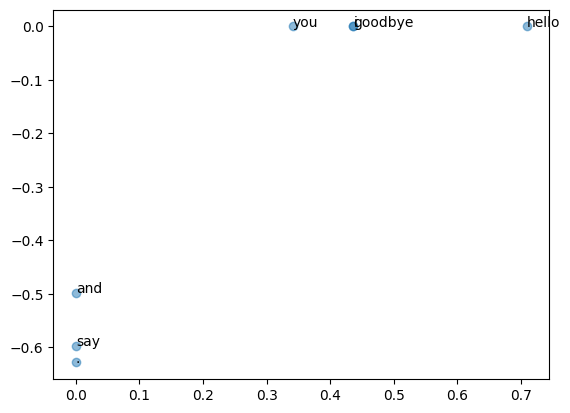

In [27]:
#次元削減後の単語ベクトルの可視化
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

これで行列の改善ができたのでより大きなコーパスを使って試してみましょう

### PTBデータセット

In [30]:
import sys
sys.path.append('..')
from datasets import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [31]:
import sys
sys.path.append('..')
import numpy as np
from datasets import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

counting  co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.

In [32]:
#結果
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.7278802394866943
 we: 0.6299450993537903
 me: 0.5555775761604309
 do: 0.5467197299003601
 anybody: 0.533714234828949

[query] year
 month: 0.6757156252861023
 quarter: 0.6243940591812134
 earlier: 0.615135133266449
 june: 0.5875838398933411
 next: 0.5865615010261536

[query] car
 luxury: 0.6211763024330139
 auto: 0.5950354337692261
 cars: 0.5102657079696655
 truck: 0.4849717319011688
 automobile: 0.4601386785507202

[query] toyota
 motor: 0.7325315475463867
 motors: 0.6748571395874023
 lexus: 0.6745177507400513
 nissan: 0.645314633846283
 honda: 0.640676736831665


コーパスを使い、コンテキストの単語をカウントして、PPMI行列に変換して、SVDによる次元削減を行うことで単語ベクトルが得られた！